In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibrationDisplay


import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read and preprocess data
df = pd.read_csv('../data/AllSeasonsM2Q2.csv')

df = df.drop('Unnamed: 0', 1)
df = df[['distance', 'angle', 'Goal']]
df = df.rename({'Goal': 'is_goal'}, axis=1)
df = df[~(df['is_goal'].isnull() | df['distance'].isnull() | df['angle'].isnull())] #remove after fix
df['is_goal'] = df['is_goal'].astype(np.int64)
df.head()

,distance,angle,is_goal
0,13.000000,67.380135,0
1,13.341664,167.005383,0
2,76.157731,60.068488,0
3,57.974132,75.004921,0
4,61.717096,63.019769,0


In [15]:
df.columns

Index(['index', 'eventType', 'period', 'periodTime', 'periodType', 'gameID',
       'teamOfShooter', 'homeOrAway', 'xCoord', 'yCoord', 'shooter', 'goalie',
       'shotType', 'emptyNet', 'strength', 'season', 'rinkSide', 'gameType',
       'totalPlayTime', 'lastEventType', 'lastEventPeriod',
       'lastEventPeriodTime', 'lastEventXCoord', 'lastEventYCoord', 'Goal',
       'EmptyNet', 'distanceFromNet', 'angle', 'gameSeconds',
       'lastEventGameSeconds', 'timeFromLastEvent', 'distanceFromLastEvent',
       'rebound', 'lastEventAngle', 'changeInAngleShot', 'speed'],
      dtype='object')

In [6]:
X = df.drop('is_goal', 1)
y = df['is_goal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train[['distance', 'angle']]

,distance,angle
143124,52.497619,72.255328
9667,29.427878,9.782407
285044,37.121422,94.635463
50783,49.000000,90.000000
241011,10.049876,95.710593
...,...,...
122591,35.805028,125.909723
304154,58.051701,79.077195
152327,9.433981,57.994617
117964,57.271284,65.224859


### Question-1:

In [7]:
### XGBoost on distance+angle ###

X_train1 = X_train[['distance', 'angle']].to_numpy().reshape(-1, 2)
X_val1 = X_val[['distance', 'angle']].to_numpy().reshape(-1, 2)

xgb_clf1 = XGBClassifier().fit(X_train1, y_train)


train_score1 = xgb_clf1.score(X_train1, y_train)
val_score1 = xgb_clf1.score(X_val1, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

[23:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.9050266312945303
Validation accuracy: 0.9063113145846958


In [35]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train1, y_train)

train_score0 = random_clf.score(X_train1, y_train)
val_score0 = random_clf.score(X_val1, y_val)

print(f'Training accuracy: {train_score0}')
print(f'Validation accuracy: {val_score0}')

Training accuracy: 0.4998671501040317
Validation accuracy: 0.49892086330935254


XGBoost (trained on distance+angle): ROC AUC=0.712
Random: ROC AUC=0.500


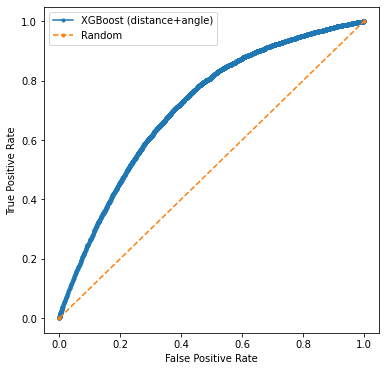

In [6]:
### ROC curve - AUC metric ###

xgb_probs1 = xgb_clf1.predict_proba(X_val1[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val1[:, :])[:,1]


xgb_auc1 = roc_auc_score(y_val, xgb_probs1)
random_auc = roc_auc_score(y_val, random_probs)

print('XGBoost (trained on distance+angle): ROC AUC=%.3f' % (xgb_auc1))
print('Random: ROC AUC=%.3f' % (random_auc))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_val, xgb_probs1)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (distance+angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

In [72]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

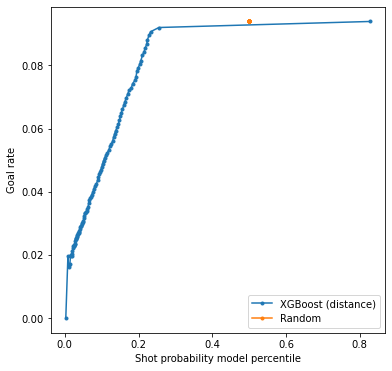

In [7]:
### goal_rate = F(shot probability model percentile) ###



percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_1.png')

plt.show()

In [8]:

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates



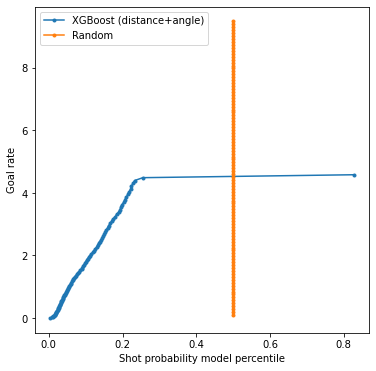

In [8]:
### cumulative portion of goals = F(shot probability model percentile) ###

percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance+angle)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_2.png')

plt.show()

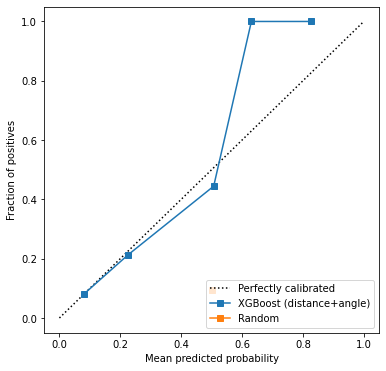

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf1, X_val1, y_val, label='XGBoost (distance+angle)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val1, y_val, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()

In [70]:
df.columns

Index(['Unnamed: 0', 'index', 'eventType', 'period', 'periodTime',
       'periodType', 'gameID', 'teamOfShooter', 'homeOrAway', 'xCoord',
       'yCoord', 'shooter', 'goalie', 'shotType', 'emptyNet', 'strength',
       'season', 'rinkSide', 'gameType', 'totalPlayTime', 'lastEventType',
       'lastEventPeriod', 'lastEventPeriodTime', 'lastEventXCoord',
       'lastEventYCoord', 'Goal', 'EmptyNet', 'distanceFromNet', 'angle',
       'gameSeconds', 'lastEventGameSeconds', 'timeFromLastEvent',
       'distanceFromLastEvent', 'rebound', 'lastEventAngle',
       'changeInAngleShot', 'speed'],
      dtype='object')

### Question-2: XGBoost classifier using all of the features:
Game seconds-
Game period-
Coordinates (x,y, separate columns)-
Shot distance-
Shot angle-
Shot type-
Empty net-
Last event type-
Coordinates of the last event (x, y, separate columns)-
Time from the last event (seconds)-
Distance from the last event-
Rebound (bool): -
Change in shot angle-
“Speed”-

In [10]:
df=pd.read_csv('../data/trainingSet.csv')

display(df.head())
df['rebound']=df['rebound'].astype(int)

FinalDf = df[['gameSeconds','period','xCoord','yCoord','distanceFromNet','angle','shotType','EmptyNet','lastEventType', 'lastEventXCoord',
       'lastEventYCoord','lastEventGameSeconds','distanceFromLastEvent','rebound', 
       'changeInAngleShot', 'speed','Goal']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()

FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)

#Frame is the dataset used fpr xgboost later
Frame=pd.concat([FinalDf,obj_df],axis=1)


display(Frame.head())



,index,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,...,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,0,Shot,1,00:51,REGULAR,2015020001,Toronto Maple Leafs,home,-55.0,6.0,...,11.0,154.275727,0.0,NaN,NaN,14.025066,0.0,5.0,5.0,Even
1,1,Shot,1,01:05,REGULAR,2015020001,Toronto Maple Leafs,home,-79.0,0.0,...,7.0,50.477718,0.0,NaN,NaN,7.211103,0.0,5.0,5.0,Even
2,2,Shot,1,01:06,REGULAR,2015020001,Toronto Maple Leafs,home,-75.0,-1.0,...,1.0,4.123106,1.0,NaN,NaN,4.123106,0.0,5.0,5.0,Even
3,3,Shot,1,01:53,REGULAR,2015020001,Toronto Maple Leafs,home,-55.0,-36.0,...,18.0,79.605276,0.0,NaN,NaN,4.422515,0.0,5.0,5.0,Even
4,4,Shot,1,02:37,REGULAR,2015020001,Toronto Maple Leafs,home,-61.0,-1.0,...,5.0,22.472205,0.0,NaN,NaN,4.494441,0.0,5.0,5.0,Even


,gameSeconds,period,xCoord,yCoord,distanceFromNet,angle,EmptyNet,lastEventXCoord,lastEventYCoord,lastEventGameSeconds,distanceFromLastEvent,rebound,changeInAngleShot,speed,Goal,shotType,lastEventType
0,51.0,1,-55.0,6.0,34.525353,79.992020,0.0,94.0,-34.0,40.0,154.275727,0,NaN,14.025066,0.0,6,5
1,65.0,1,-79.0,0.0,10.000000,90.000000,0.0,-37.0,-28.0,58.0,50.477718,0,NaN,7.211103,0.0,3,3
2,66.0,1,-75.0,-1.0,14.035669,94.085617,0.0,-79.0,0.0,65.0,4.123106,1,NaN,4.123106,0.0,3,14
3,113.0,1,-55.0,-36.0,49.517674,136.636577,0.0,-91.0,35.0,95.0,79.605276,0,NaN,4.422515,0.0,6,5
4,157.0,1,-61.0,-1.0,28.017851,92.045408,0.0,-69.0,-22.0,152.0,22.472205,0,NaN,4.494441,0.0,4,1


In [11]:
df_f = Frame.dropna()
print(df_f.shape)
print(df_f.columns)
X = df_f.drop('Goal',axis=1)
y = df_f['Goal'].to_numpy()

X_trainXG_All, X_valXG_All, y_trainXG_All, y_valXG_All = train_test_split(X, y, test_size=0.2, random_state=0)


(55365, 17)
Index(['gameSeconds', 'period', 'xCoord', 'yCoord', 'distanceFromNet', 'angle',
       'EmptyNet', 'lastEventXCoord', 'lastEventYCoord',
       'lastEventGameSeconds', 'distanceFromLastEvent', 'rebound',
       'changeInAngleShot', 'speed', 'Goal', 'shotType', 'lastEventType'],
      dtype='object')


### XGBoost using all features only encoding  (no feature selection) 

[00:19:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.9199629729973811
Validation accuracy: 0.90264607604082


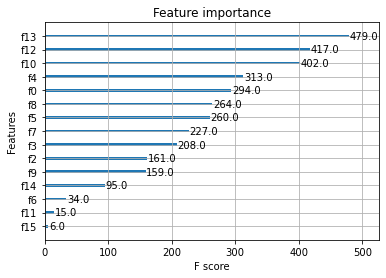

In [32]:
### XGBoost using all features  ###
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint



X_train1XG_All = X_trainXG_All.to_numpy().reshape(-1, len(X_trainXG_All.columns))
X_val1XG_All = X_valXG_All.to_numpy().reshape(-1, len(X_trainXG_All.columns))

xgb_clf2 = XGBClassifier().fit(X_train1XG_All, y_trainXG_All)


plot_importance(xgb_clf2)


train_score1 = xgb_clf2.score(X_train1XG_All, y_trainXG_All)
val_score1 = xgb_clf2.score(X_val1XG_All, y_valXG_All)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

### Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

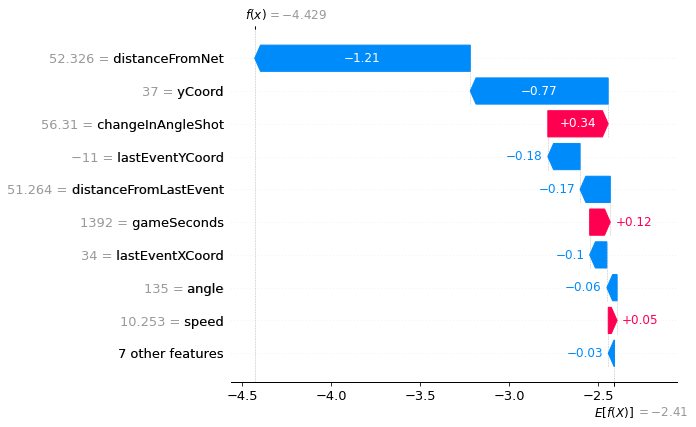

In [42]:
import shap

explainer = shap.Explainer(xgb_clf2)
shap_values = explainer(X_trainXG_All)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Training accuracy: 0.4993904091032241
Validation accuracy: 0.49932267678136005
XGBoost (trained on all ffeatures): ROC AUC=0.763
Random: ROC AUC=0.500


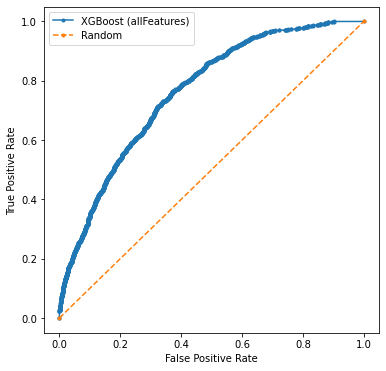

In [33]:
### ROC curve - AUC metric ###
random_clf2 = DummyClassifier(strategy="uniform").fit(X_trainXG_All, y_trainXG_All)

train_score2 = random_clf2.score(X_trainXG_All, y_trainXG_All)
val_score2 = random_clf2.score(X_val1XG_All, y_valXG_All)

print(f'Training accuracy: {train_score2}')
print(f'Validation accuracy: {val_score2}')

xgb_probs2 = xgb_clf2.predict_proba(X_val1XG_All[:, :])[:,1]
random_probs2 = random_clf2.predict_proba(X_val1XG_All[:, :])[:,1]


xgb_auc2 = roc_auc_score(y_valXG_All, xgb_probs2)
random_auc2 = roc_auc_score(y_valXG_All, random_probs2)

print('XGBoost (trained on all ffeatures): ROC AUC=%.3f' % (xgb_auc2))
print('Random: ROC AUC=%.3f' % (random_auc2))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_valXG_All, xgb_probs2)
random_fpr, random_tpr, _ = roc_curve(y_valXG_All, random_probs2)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (allFeatures)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

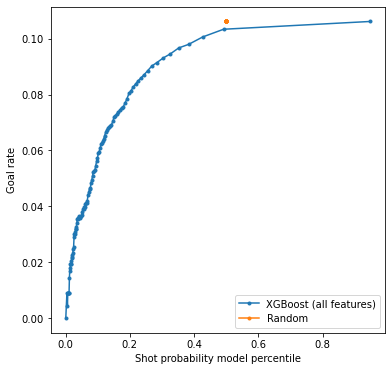

In [74]:
### goal_rate = F(shot probability model percentile) ###



percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs2, y_valXG_All)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs2, y_valXG_All)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (all features)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()



plt.show()

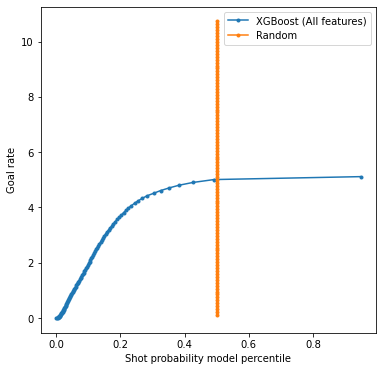

In [75]:
percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs2, y_valXG_All)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs2, y_valXG_All)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (All features)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()



plt.show()

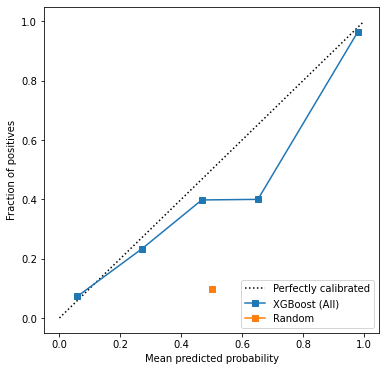

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf2, X_valXG_All, y_valXG_All, label='XGBoost (All)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_valXG_All, y_valXG_All, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()

### Feature selection

In [11]:
### should run previous part to have Frame
df_f = Frame.dropna()

X = df_f.drop('Goal',axis=1)
y = df_f['Goal'].to_numpy()
df_f.shape

(56164, 18)

In [116]:
display(df_f)

,gameSeconds,period,xCoord,yCoord,distanceFromNet,angle,EmptyNet,lastEventXCoord,lastEventYCoord,lastEventGameSeconds,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,Goal,shotType,lastEventType
10,625,1,34.0,-25.0,60.415230,65.556045,0,34.0,20.0,616,45.000000,1,109.983107,44.427061,5.000000,0,2,13
11,626,1,82.0,3.0,7.615773,113.198591,0,34.0,-25.0,625,55.569776,1,65.556045,47.642545,55.569776,1,0,13
14,769,1,34.0,-1.0,55.009090,88.958373,0,69.0,-8.0,764,35.693137,1,68.198591,20.759783,7.138627,1,2,13
23,1263,2,-55.0,-21.0,39.962482,121.701430,0,45.0,-27.0,1254,100.179838,1,101.392136,20.309294,11.131093,0,6,13
26,1328,2,-87.0,8.0,8.246211,14.036243,0,-35.0,-19.0,1322,58.591808,1,109.384516,95.348272,9.765301,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305756,609,2,79.0,-20.0,10.198039,26.565051,0,-75.0,-3.0,608,4.123106,1,102.094757,0.784825,4.123106,1,2,13
305770,1096,2,34.0,28.0,59.076222,116.980231,0,34.0,37.0,1095,70.256672,1,123.929797,67.888857,70.256672,0,6,13
305774,1280,3,81.0,-11.0,12.529964,36.027373,0,79.0,-20.0,1279,14.035669,1,26.565051,34.824489,14.035669,0,6,13
305776,1302,3,36.0,-20.0,19.849433,69.325575,0,34.0,-14.0,1287,40.012498,1,75.718904,26.633287,2.667500,0,2,13


In [148]:
## Removing features with low variance
##threshold here 0.8
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
vt=sel.fit_transform(X)
print(len(X.columns))
print(type(vt))
X_HighVar=X[X.columns[sel.get_support(indices=True)]] 
print("removed Values: ")
index=set(range(17)) - set(sel.get_support(indices=True))
print(str([X.columns[i] for i  in index]))

X_HighVar

17
<class 'numpy.ndarray'>
removed Values: 
['lastEventType', 'rebound', 'EmptyNet']


,gameSeconds,period,xCoord,yCoord,distanceFromNet,angle,lastEventXCoord,lastEventYCoord,lastEventGameSeconds,distanceFromLastEvent,lastEventAngle,changeInAngleShot,speed,shotType
10,625,1,34.0,-25.0,60.415230,65.556045,34.0,20.0,616,45.000000,109.983107,44.427061,5.000000,2
11,626,1,82.0,3.0,7.615773,113.198591,34.0,-25.0,625,55.569776,65.556045,47.642545,55.569776,0
14,769,1,34.0,-1.0,55.009090,88.958373,69.0,-8.0,764,35.693137,68.198591,20.759783,7.138627,2
23,1263,2,-55.0,-21.0,39.962482,121.701430,45.0,-27.0,1254,100.179838,101.392136,20.309294,11.131093,6
26,1328,2,-87.0,8.0,8.246211,14.036243,-35.0,-19.0,1322,58.591808,109.384516,95.348272,9.765301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305756,609,2,79.0,-20.0,10.198039,26.565051,-75.0,-3.0,608,4.123106,102.094757,0.784825,4.123106,2
305770,1096,2,34.0,28.0,59.076222,116.980231,34.0,37.0,1095,70.256672,123.929797,67.888857,70.256672,6
305774,1280,3,81.0,-11.0,12.529964,36.027373,79.0,-20.0,1279,14.035669,26.565051,34.824489,14.035669,6
305776,1302,3,36.0,-20.0,19.849433,69.325575,34.0,-14.0,1287,40.012498,75.718904,26.633287,2.667500,2


It is suggested that we remove EmptyNet => don't agree ? 

In [28]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import seaborn as sn
from matplotlib.pyplot import figure
from sklearn import linear_model
from sklearn import feature_selection 
from sklearn.pipeline import Pipeline

In [21]:
X['rebound'].unique()

array([1])

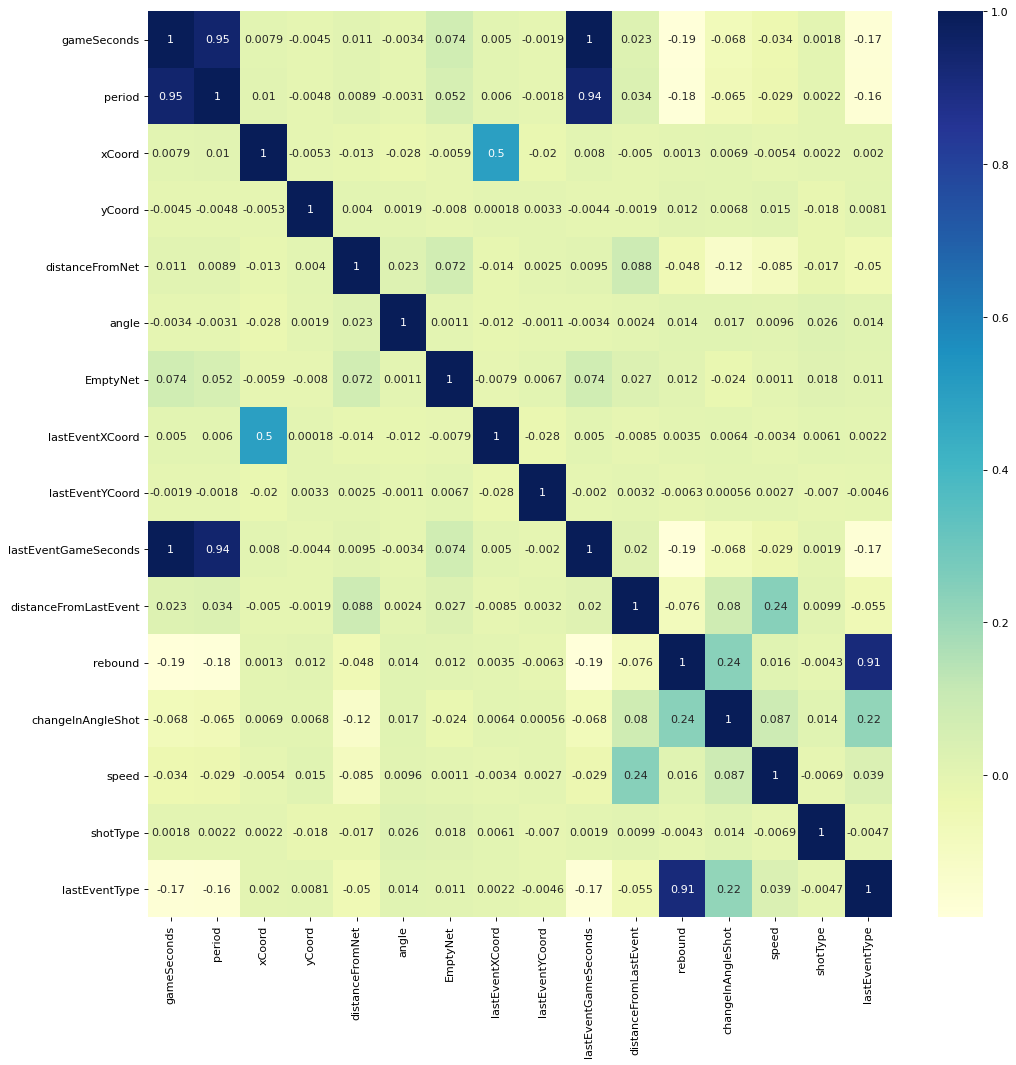

In [29]:
corrMatrix = X.corr()

figure(figsize=(15, 15), dpi=80)
sn.heatmap(corrMatrix, annot=True,cmap="YlGnBu")
plt.show()

## Lasso

In [39]:
clf = linear_model.Lasso(alpha=0.1)
selector = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_trainXG_All,y_trainXG_All)
selected_feature_indices = np.where(selector._get_support_mask())[0] 
res_list = [X_trainXG_All.columns[i] for i in selected_feature_indices] 
res_list

['distanceFromNet', 'distanceFromLastEvent', 'speed']

In [47]:
from sklearn.linear_model import LogisticRegression
X_trainXG_All, X_valXG_All, y_trainXG_All, y_valXG_All = train_test_split(X, y, test_size=0.2, random_state=0)

clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', XGBClassifier())
])
clf.fit(X_trainXG_All, y_trainXG_All)
predictions = clf.predict(X_valXG_All)
accuracy = accuracy_score(y_valXG_All, predictions)
print(" Accuracy: %.1f%%" % ( accuracy*100.0))



[00:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Accuracy: 90.0%


In [49]:


 
# load data

X_trainXG_All, X_valXG_All, y_trainXG_All, y_valXG_All = train_test_split(X, y, test_size=0.2, random_state=0)


# fit model on all training data
model = XGBClassifier()
model.fit(X_trainXG_All, y_trainXG_All)
# make predictions for test data and evaluate
predictions = model.predict(X_valXG_All)
accuracy = accuracy_score(y_valXG_All, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    print(type(selection))
    select_X_train = selection.transform(X_trainXG_All)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_trainXG_All)
    # eval model
    select_X_test = selection.transform(X_valXG_All)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_valXG_All, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    import shap
    explainer = shap.Explainer(selection)
    shap_values = explainer(select_X_train)

    
    shap.plots.waterfall(shap_values[0])

[00:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.26%
<class 'sklearn.feature_selection._from_model.SelectFromModel'>
[00:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=16, Accuracy: 90.26%


Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1,
                                        enable_categorical=False, gamma=0,
                                        gpu_id=-1, importance_type=None,
                                        interaction_constraints='',
                                        learning_rate=0.300000012,
                                        max_delta_step=0, max_depth=6,
                                        min_child_weight=1, missing=nan,
                                        monotone_constraints='()',
                                        n_estimators=100, n_jobs=12,
                                        num_parallel_tree=1, predictor='auto',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1,
                                        subsample=1, tree_method='exact',
                                        validate_parameters=1, verbosity=None),
                prefit=True, threshold=0.0)